In [1]:
# Basic libraries
import os
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!wget -O images.zip "https://mmmutgkp-my.sharepoint.com/:u:/g/personal/2022071039_mmmut_ac_in/EZJgEXxR0VRFmqrti2oVJtQBmT55n9ZG-ssxWTWbtRMHgw?download=1"


--2025-06-20 11:40:08--  https://mmmutgkp-my.sharepoint.com/:u:/g/personal/2022071039_mmmut_ac_in/EZJgEXxR0VRFmqrti2oVJtQBmT55n9ZG-ssxWTWbtRMHgw?download=1
Resolving mmmutgkp-my.sharepoint.com (mmmutgkp-my.sharepoint.com)... 52.107.249.141, 52.107.249.146, 52.107.249.173, ...
Connecting to mmmutgkp-my.sharepoint.com (mmmutgkp-my.sharepoint.com)|52.107.249.141|:443... connected.
HTTP request sent, awaiting response... 302 
Location: /personal/2022071039_mmmut_ac_in/Documents/Images_folder.zip?ga=1 [following]
--2025-06-20 11:40:09--  https://mmmutgkp-my.sharepoint.com/personal/2022071039_mmmut_ac_in/Documents/Images_folder.zip?ga=1
Reusing existing connection to mmmutgkp-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 4381559472 (4.1G) [application/x-zip-compressed]
Saving to: ‘images.zip’

images.zip          100%[===================>]   4.08G  45.6MB/s    in 1m 44s  

2025-06-20 11:41:54 (40.0 MB/s) - ‘images.zip’ saved [4381559472/4381559472]



In [4]:
!unzip -q images.zip -d images_folder

In [5]:

from google.colab import files
uploaded = files.upload()

Saving captions.txt.zip to captions.txt.zip


In [6]:
!unzip -q captions.txt.zip -d captions_folder

In [7]:
# Setting the input and output directory
INPUT_DIR = '/content'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/working'

In [8]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR,  'images_folder', 'Images_folder')

# Acceptable image extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    if not img_name.lower().endswith(valid_extensions):
        continue  # Skip non-image files
    try:
        # Load the image from file
        img_path = os.path.join(img_dir, img_name)
        image = load_img(img_path, target_size=(224, 224))
        # Convert image pixels to a numpy array
        image = img_to_array(image)
        # Reshape the data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Preprocess the image for ResNet50
        image = preprocess_input(image)
        # Extract features using the pre-trained ResNet50 model
        image_feature = model.predict(image, verbose=0)
        # Get the image ID by removing the file extension
        image_id = img_name.split('.')[0]
        # Store the extracted feature in the dictionary with the image ID as the key
        image_features[image_id] = image_feature
    except Exception as e:
        print(f"Error processing image '{img_name}': {e}")
        # traceback.print_exc()


  0%|          | 0/31785 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Skipped results.csv due to error: cannot identify image file <_io.BytesIO object at 0x7c021ff18090>
Skipped flickr30k_images due to error: [Errno 21] Is a directory: '/content/images_folder/flickr30k_images'


In [ ]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [9]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

Now 2nd segment of codes.

In [10]:
with open(os.path.join(INPUT_DIR, 'captions_folder', 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [11]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/158916 [00:00<?, ?it/s]

Total number of captions: 158915


In [14]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [15]:
# before preprocess of text
image_to_captions_mapping['1000523639']

[' Two people in the photo are playing the guitar and the other is poking at him .',
 ' A man in green holds a guitar while the other man observes his shirt .',
 ' A man is fixing the guitar players costume .',
 " a guy stitching up another man 's coat .",
 ' the two boys playing guitar']

In [16]:
# preprocess the text
clean(image_to_captions_mapping)

In [17]:
# after preprocess of text
image_to_captions_mapping['1000523639']

['startseq two people in the photo are playing the guitar and the other is poking at him endseq',
 'startseq man in green holds guitar while the other man observes his shirt endseq',
 'startseq man is fixing the guitar players costume endseq',
 'startseq guy stitching up another man coat endseq',
 'startseq the two boys playing guitar endseq']

In [18]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [19]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [20]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [21]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [29]:
import pickle

# Set path to your desired folder in Google Drive
save_path = '/content/drive/MyDrive/Colab Notebooks/working/tokenizer.pkl'

# Save the tokenizer
with open(save_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


In [23]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 19746
Maximum Caption Length: 74


In [24]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [25]:
import numpy as np
import tensorflow as tf # Explicitly import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from math import ceil # Need ceil for steps_per_epoch

# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys:
            captions = image_to_captions_mapping[image_id]

            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    # Input and output sequence
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Right-pad the input sequence (cuDNN-compatible)
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]

                    # One-hot encode the output token
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append to batch
                    X1_batch.append(features[image_id][0])  # Image feature vector
                    X2_batch.append(in_seq)                 # Text input sequence
                    y_batch.append(out_seq)                 # One-hot encoded output word

                    batch_count += 1

                    # Yield the batch when full
                    if batch_count == batch_size:
                        # Changed the yield structure to (inputs_tuple, output_array)
                        yield ((np.array(X1_batch), np.array(X2_batch)), np.array(y_batch))
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

# The rest of the training loop remains the same, as model.fit should now be able to
# infer the output signature correctly from the modified generator output format.

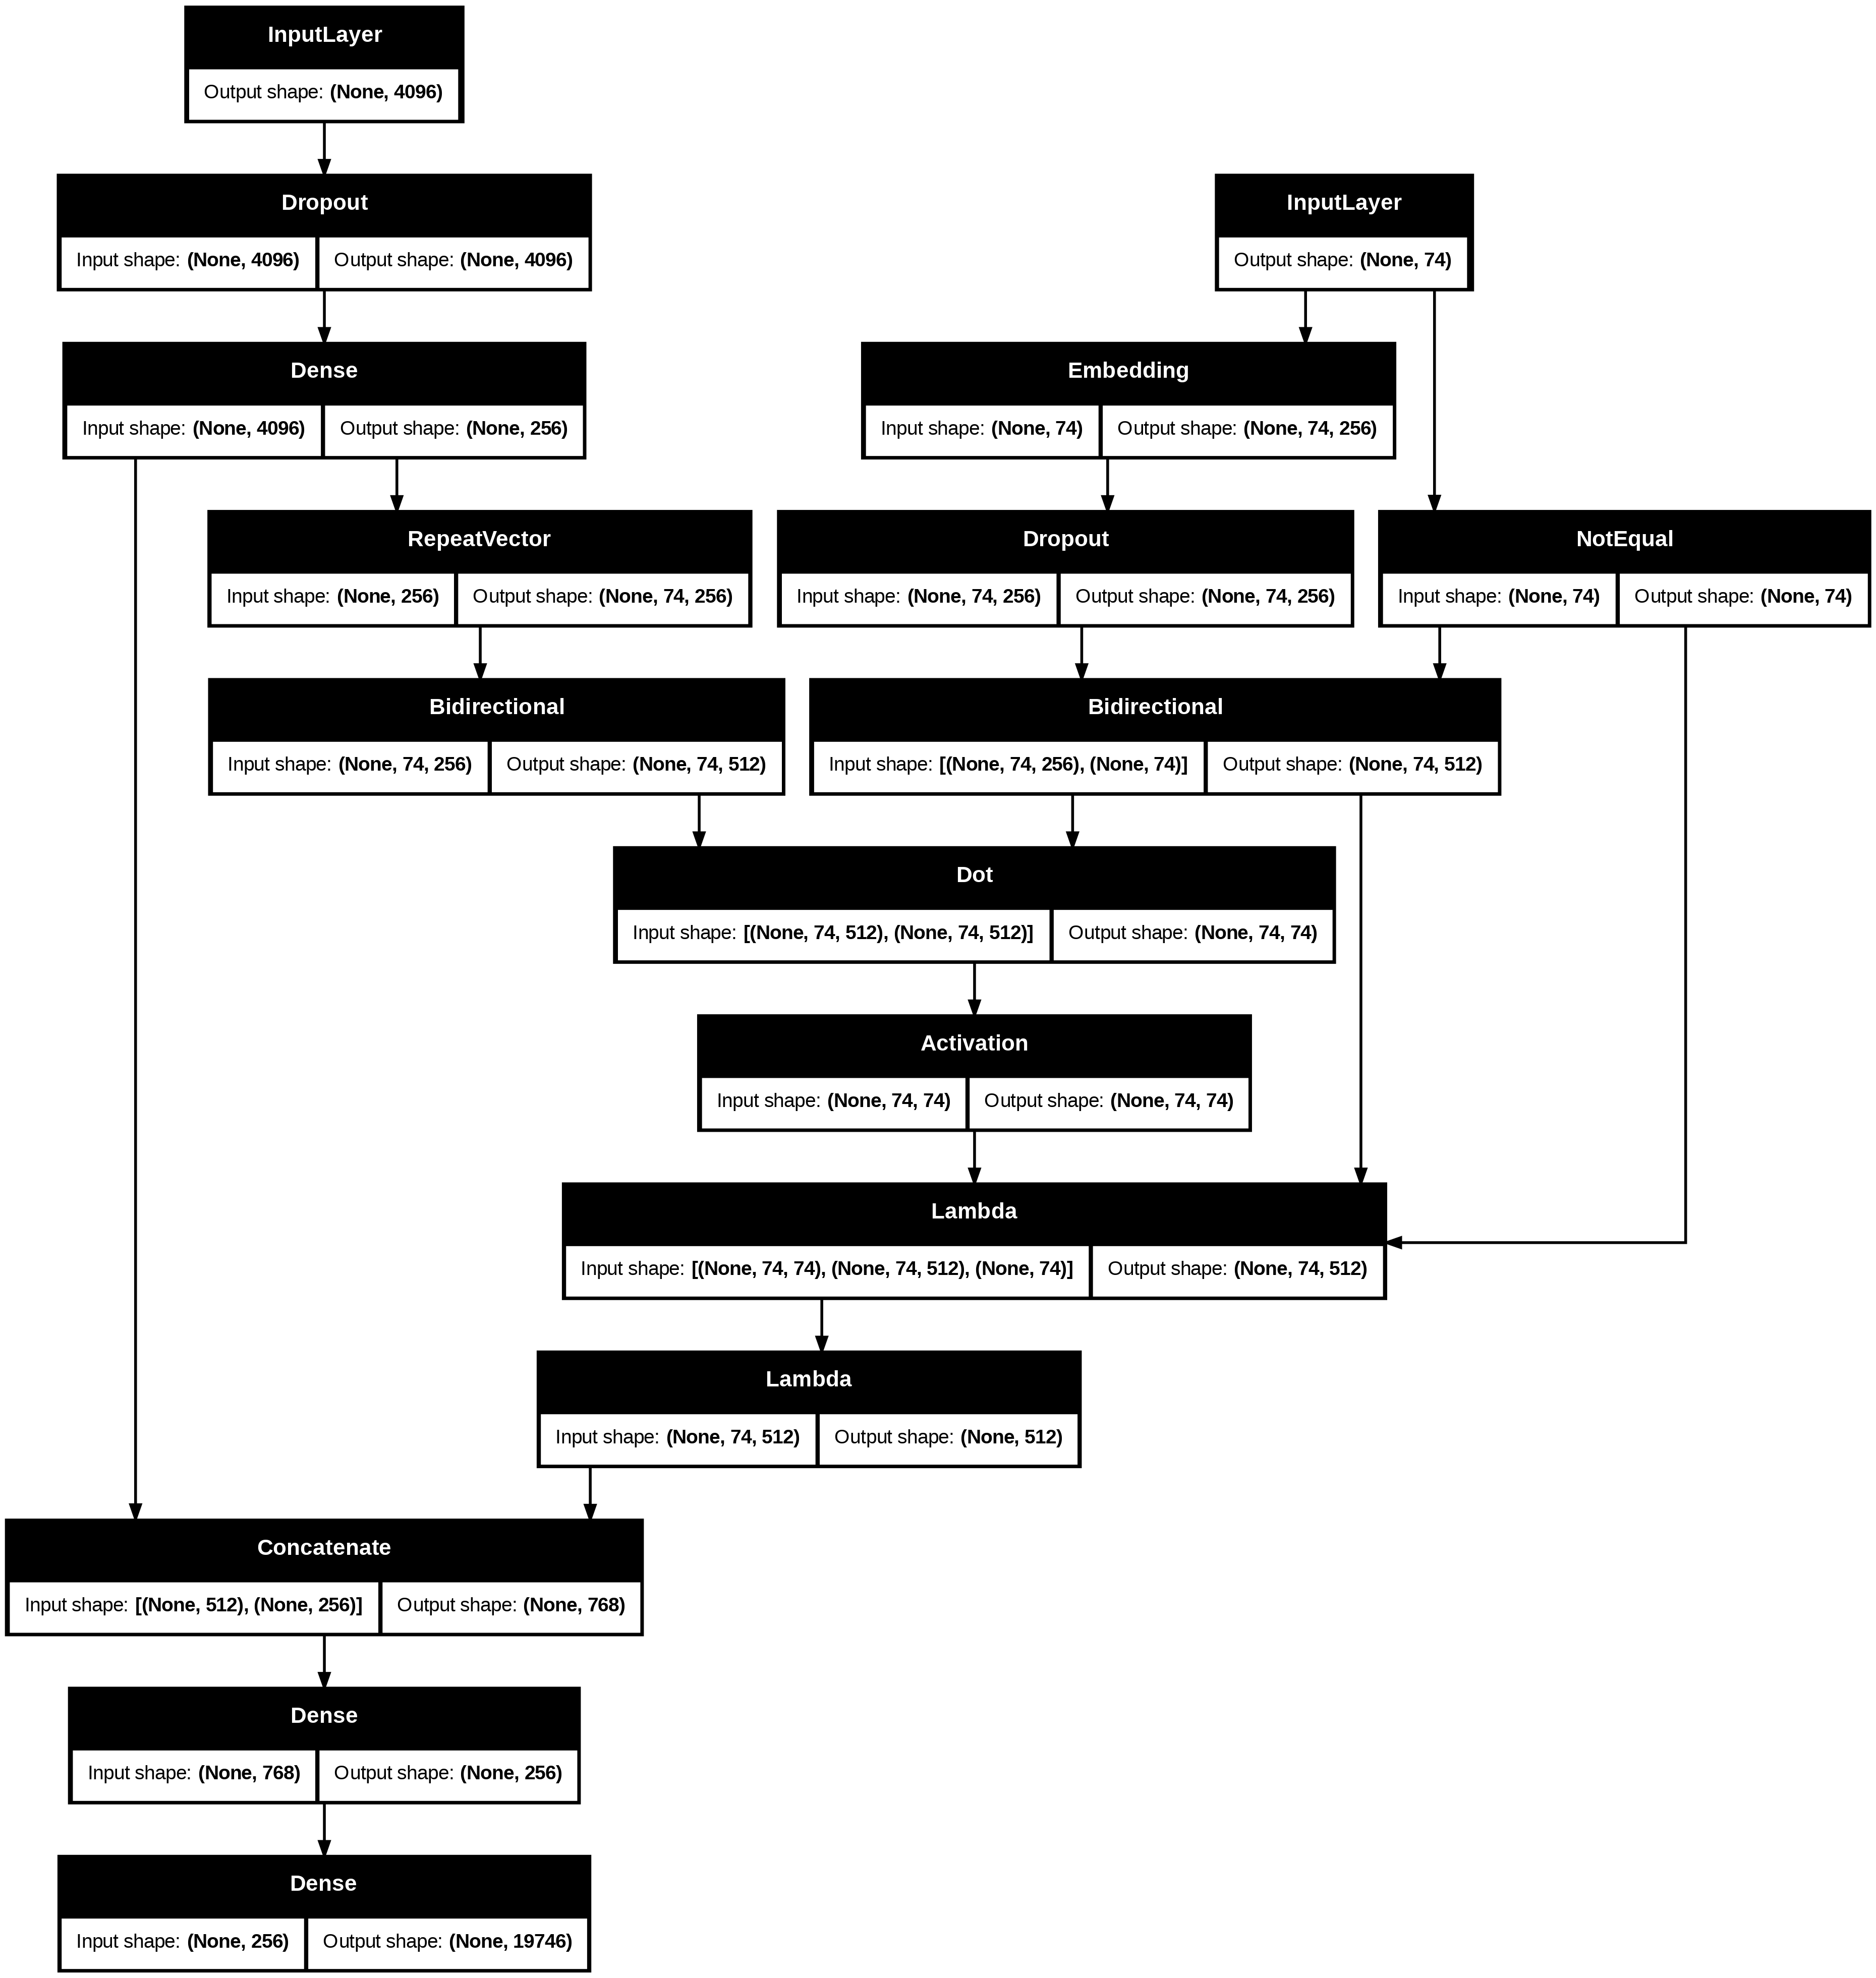

In [26]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

In [27]:
# Set the number of epochs, batch size
epochs = 50
batch_size = 96

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - loss: 7.0457 - val_loss: 6.4075
Epoch 2/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 5.4360 - val_loss: 6.5976
Epoch 3/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 5.0873 - val_loss: 6.4820
Epoch 4/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 4.5650 - val_loss: 6.6254
Epoch 5/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 4.0906 - val_loss: 7.0652
Epoch 6/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 3.7149 - val_loss: 8.0324
Epoch 7/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 3.4349 - val_loss: 8.9100
Epoch 8/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 3.1676 - val_loss: 8.7748
Epoch 9/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 2.9976 - val_loss: 8.5245
Epoch 10/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 2.8376 - val_loss: 8.9341
Epoch 11/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 2.6464 - val_loss: 9.4383
Epoch 12/50
298/298 ━━━━━━━━━━

In [28]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.keras')

In [30]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [31]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    caption = 'startseq'

    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # ✅ Right-pad the sequence to make it cuDNN-compatible
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')

        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        predicted_index = np.argmax(yhat)
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Append the predicted word
        if predicted_word is None:
            break
        caption += " " + predicted_word

        if predicted_word == 'endseq':
            break

    return caption


In [38]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()

    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/3179 [00:00<?, ?it/s]

BLEU-1: 0.418037
BLEU-2: 0.170954


In [34]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "images_folder", "Images_folder", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    return(y_pred)

In [35]:
!pip install gTTS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1


In [36]:
from gtts import gTTS
from IPython.display import Audio

def speak_caption(caption):
    if not caption or not isinstance(caption, str):
        print("❌ Invalid caption. Nothing to speak.")
        return

    # Remove 'startseq' and 'endseq', then strip whitespace
    clean_text = caption.replace('startseq', '').replace('endseq', '').strip()

    if not clean_text:
        print("⚠️ Caption is empty after cleaning tags.")
        return

    # Convert to speech and return audio player
    tts = gTTS(text=clean_text, lang='en')
    tts.save("caption.mp3")
    return Audio("caption.mp3", autoplay=True)


---------------------Actual---------------------
startseq the white out conditions of snow on the ground seem to almost obliverate the details of man dressed for the cold weather in heavy jacket and red hat riding bicycle in suburban neighborhood endseq
startseq young boy rides bike down snow covered road endseq
startseq boy in the snow riding his bike down the street endseq
startseq person riding bike on snowy road endseq
startseq person riding bike in snow endseq
--------------------Predicted--------------------
startseq person riding bike on snowy road endseq


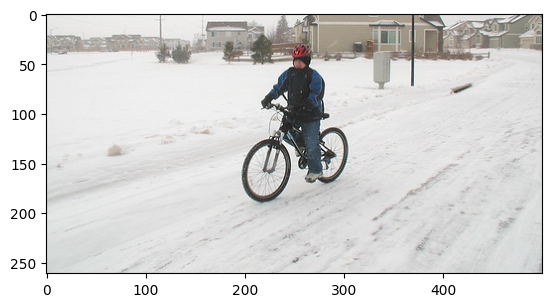

In [40]:
caption = generate_caption("101001624.jpg")
speak_caption(caption)


In [ ]:
# Save model
model.save('image_caption_model.h5')
files.download('image_caption_model.h5')

# Save tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
files.download('tokenizer.pkl')

# Save mapping dictionary
import json
with open('mapping.json', 'w') as f:
    json.dump(mapping, f)
files.download('mapping.json')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/MyDrive/image_caption_model.h5')
with open('/content/drive/MyDrive/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


The error message `InvalidArgumentError: Graph execution error: ... assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]` indicates that there is an issue with the mask being passed to the RNN layer when using cuDNN. cuDNN requires right-padded sequences, but the sequences being passed do not meet this requirement.

To fix this, you need to disable cuDNN for the RNN layer by adding `use_cudnn=False` to its definition. Since the model definition is not in the provided notebook state, I will provide an example of how you might modify an LSTM layer within a model definition to include this argument. You will need to apply this change to your actual model definition cell.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# This is a placeholder model definition to demonstrate the fix.
# You will need to replace this with your actual model definition.
# Assuming you have defined:
# vocab_size, max_caption_length, embedding_dim, units

# image feature layers
input_image = Input(shape=(4096,)) # Adjust shape if needed
fe1 = Dropout(0.5)(input_image)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input_sequence = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_sequence)
se2 = Dropout(0.5)(se1)
# Add use_cudnn=False to the LSTM layer
se3 = LSTM(units, use_cudnn=False)(se2) # <--- FIX APPLIED HERE

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)

# create the model
model = Model(inputs=[input_image, input_sequence], outputs=output)

# Compile the model (example, adjust as needed)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summary of the model (optional)
# model.summary()

## **Image Extraction **

In [ ]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR,  'images_folder', 'Images_folder')

# Acceptable image extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    if not img_name.lower().endswith(valid_extensions):
        continue  # Skip non-image files
    try:
        # Load the image from file
        img_path = os.path.join(img_dir, img_name)
        image = load_img(img_path, target_size=(224, 224))
        # Convert image pixels to a numpy array
        image = img_to_array(image)
        # Reshape the data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Preprocess the image for ResNet50
        image = preprocess_input(image)
        # Extract features using the pre-trained ResNet50 model
        image_feature = model.predict(image, verbose=0)
        # Get the image ID by removing the file extension
        image_id = img_name.split('.')[0]
        # Store the extracted feature in the dictionary with the image ID as the key
        image_features[image_id] = image_feature
    except Exception as e:
        print(f"Error processing image '{img_name}': {e}")
        # traceback.print_exc()


  0%|          | 0/31784 [00:00<?, ?it/s]

In [ ]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [ ]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

# Loading Caption Data

In [ ]:
with open(os.path.join(INPUT_DIR, 'captions_folder', 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [ ]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/158916 [00:00<?, ?it/s]

Total number of captions: 158915


# Preprocessing Captions: Getting Them Ready


In [ ]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
image_to_captions_mapping['1000523639']

[' Two people in the photo are playing the guitar and the other is poking at him .',
 ' A man in green holds a guitar while the other man observes his shirt .',
 ' A man is fixing the guitar players costume .',
 " a guy stitching up another man 's coat .",
 ' the two boys playing guitar']

In [ ]:
# preprocess the text
clean(image_to_captions_mapping)

In [ ]:
# after preprocess of text
image_to_captions_mapping['1000523639']

['startseq two people in the photo are playing the guitar and the other is poking at him endseq',
 'startseq man in green holds guitar while the other man observes his shirt endseq',
 'startseq man is fixing the guitar players costume endseq',
 'startseq guy stitching up another man coat endseq',
 'startseq the two boys playing guitar endseq']

In [ ]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [ ]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [ ]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [ ]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [ ]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 19746
Maximum Caption Length: 74


# Train Test Split

In [ ]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
import numpy as np
import tensorflow as tf # Explicitly import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from math import ceil # Need ceil for steps_per_epoch

# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys:
            captions = image_to_captions_mapping[image_id]

            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    # Input and output sequence
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Right-pad the input sequence (cuDNN-compatible)
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]

                    # One-hot encode the output token
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append to batch
                    X1_batch.append(features[image_id][0])  # Image feature vector
                    X2_batch.append(in_seq)                 # Text input sequence
                    y_batch.append(out_seq)                 # One-hot encoded output word

                    batch_count += 1

                    # Yield the batch when full
                    if batch_count == batch_size:
                        # Changed the yield structure to (inputs_tuple, output_array)
                        yield ((np.array(X1_batch), np.array(X2_batch)), np.array(y_batch))
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

# The rest of the training loop remains the same, as model.fit should now be able to
# infer the output signature correctly from the modified generator output format.

# LSTM Model Training

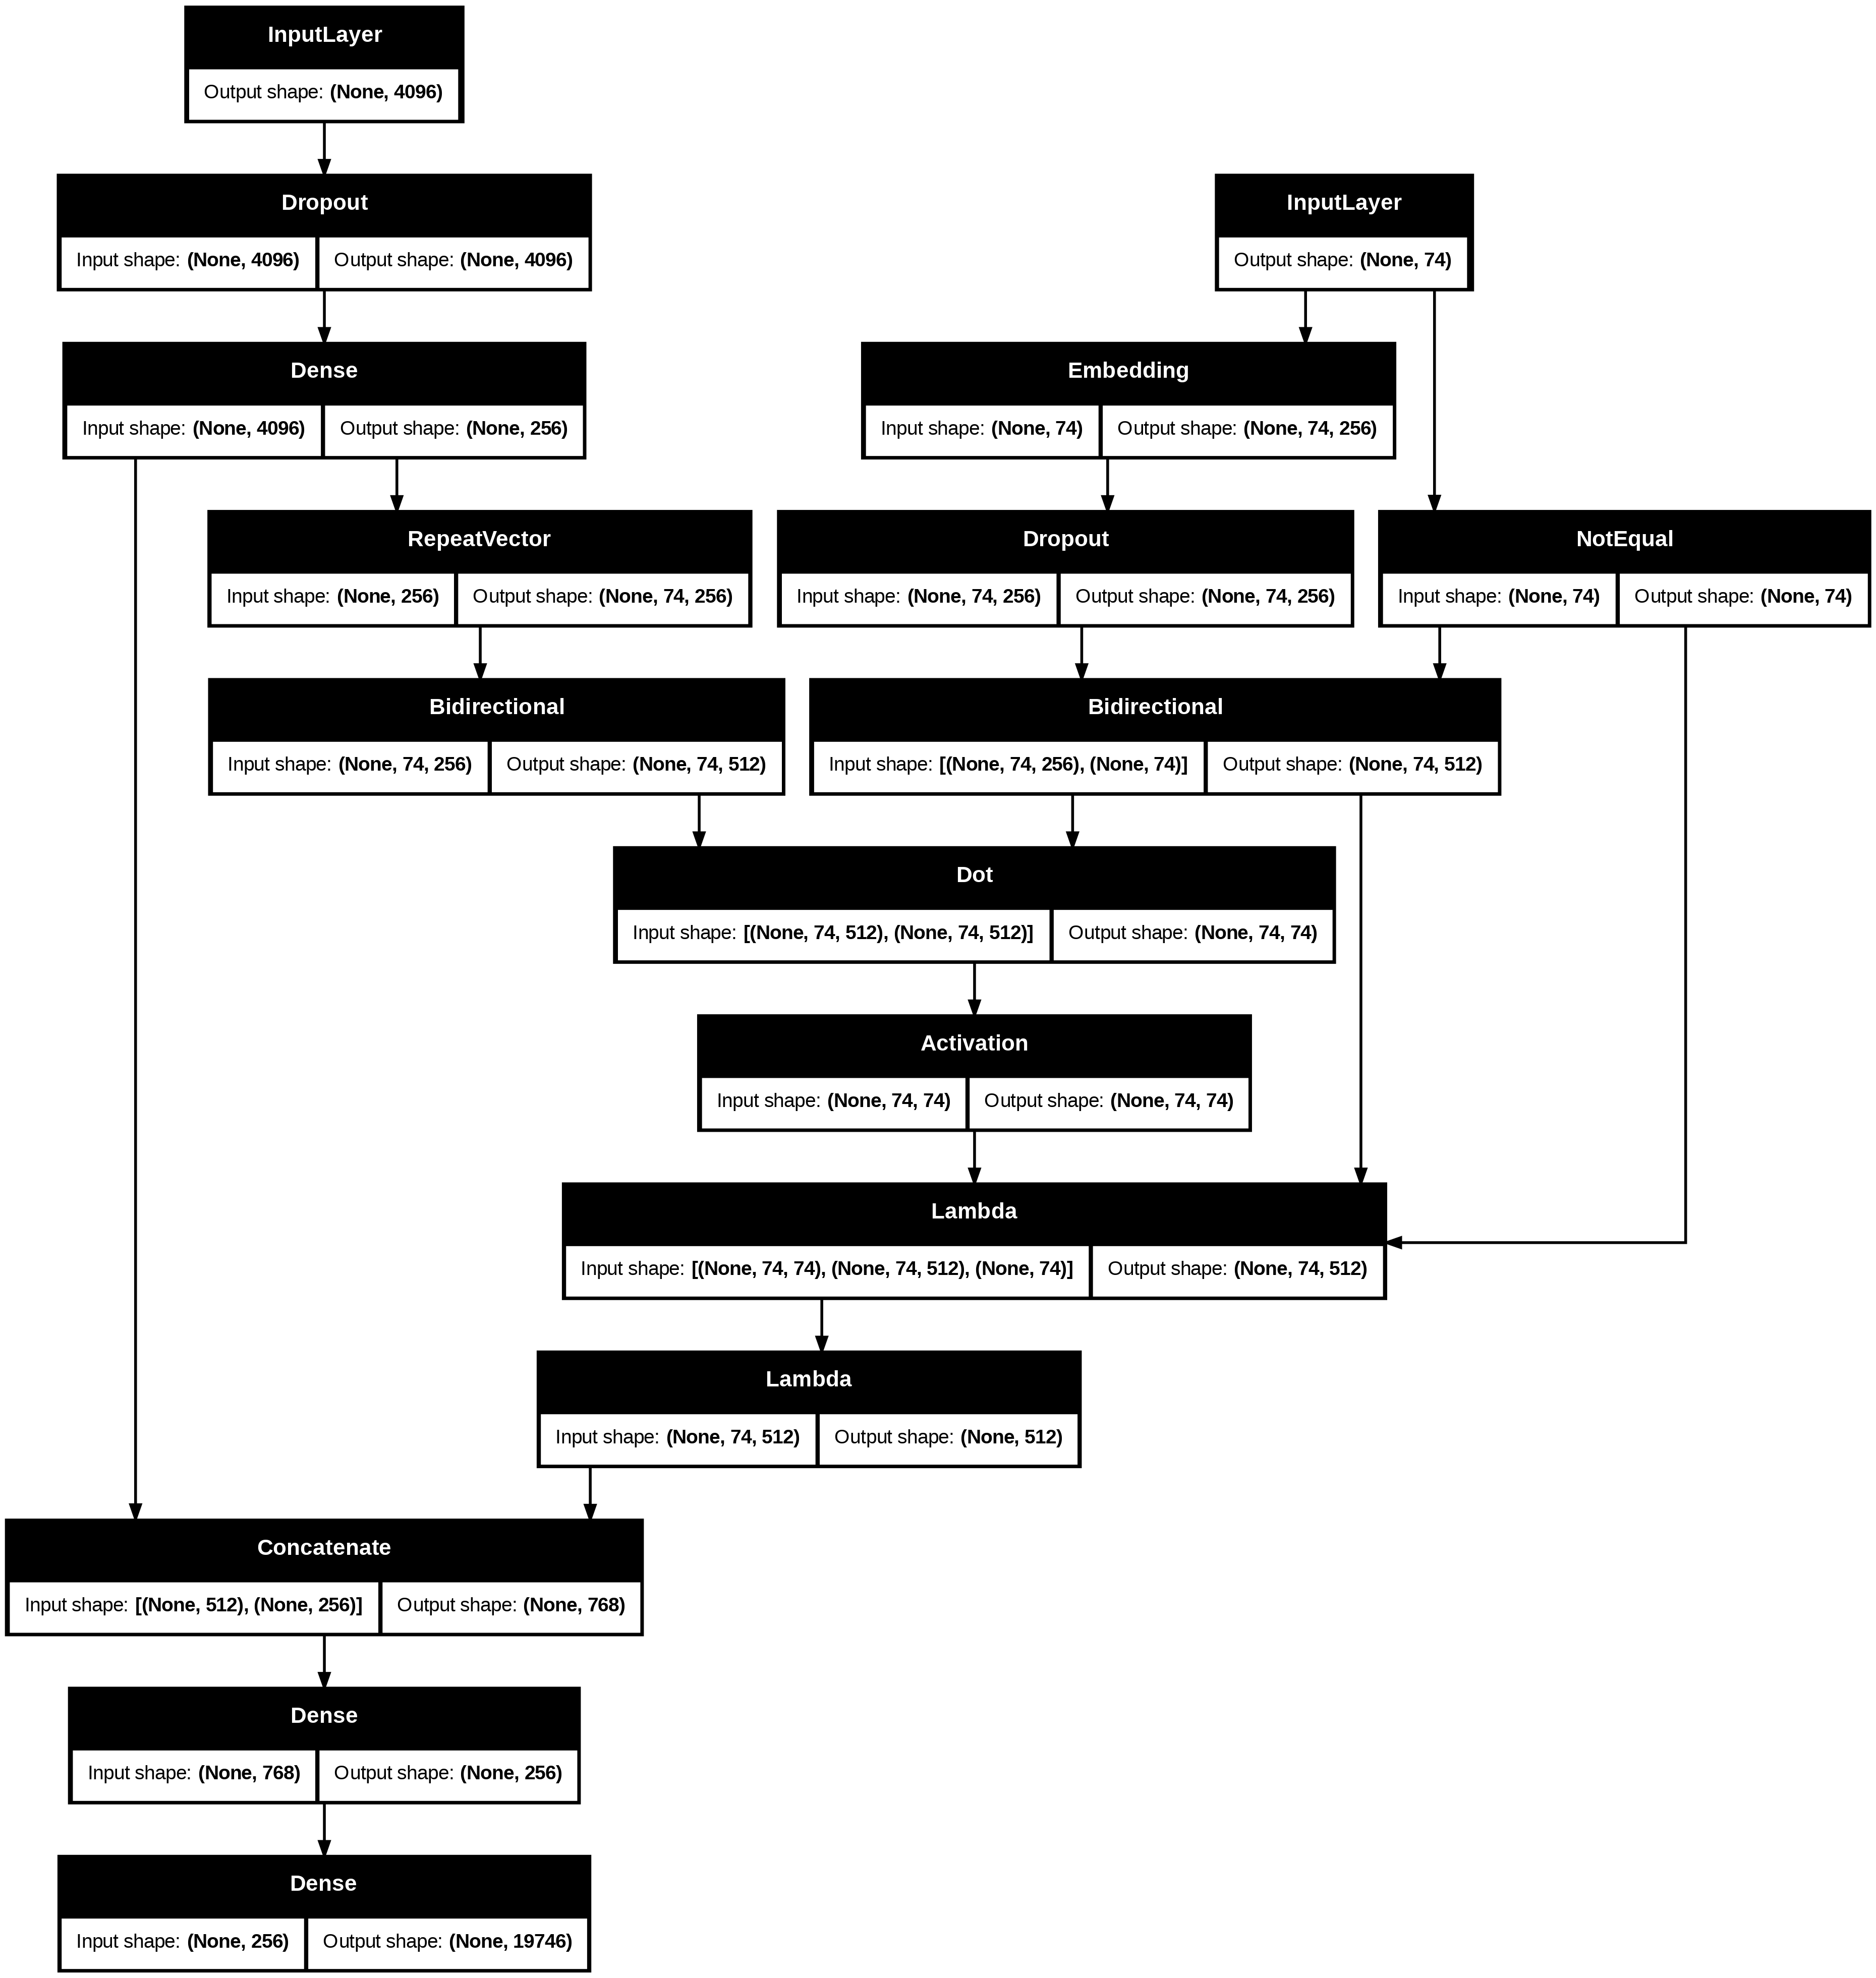

In [ ]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

# **Model Learning**

In [ ]:
# Set the number of epochs, batch size
epochs = 50
batch_size = 96

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

NameError: name 'ceil' is not defined

In [ ]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.keras')

# Captions Generation

In [ ]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [ ]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    caption = 'startseq'

    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # ✅ Right-pad the sequence to make it cuDNN-compatible
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')

        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        predicted_index = np.argmax(yhat)
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Append the predicted word
        if predicted_word is None:
            break
        caption += " " + predicted_word

        if predicted_word == 'endseq':
            break

    return caption


In [ ]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()

    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.436112
BLEU-2: 0.188980


In [ ]:
import os
import pickle

# Create directory in Drive if it doesn't exist
drive_path = '/content/drive/MyDrive/Colab Notebooks/working'
os.makedirs(drive_path, exist_ok=True)

# Save tokenizer
tokenizer_save_path = os.path.join(drive_path, 'tokenizer.pkl')
with open(tokenizer_save_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer saved to {tokenizer_save_path}")


Tokenizer saved to /content/drive/MyDrive/Colab Notebooks/working/tokenizer.pkl


# Predicting captions for Images

In [ ]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "images_folder", "Images_folder", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    return(y_pred)

In [ ]:
!pip install gTTS


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1


In [ ]:
from gtts import gTTS
from IPython.display import Audio

def speak_caption(caption):
    if not caption or not isinstance(caption, str):
        print("❌ Invalid caption. Nothing to speak.")
        return

    # Remove 'startseq' and 'endseq', then strip whitespace
    clean_text = caption.replace('startseq', '').replace('endseq', '').strip()

    if not clean_text:
        print("⚠️ Caption is empty after cleaning tags.")
        return

    # Convert to speech and return audio player
    tts = gTTS(text=clean_text, lang='en')
    tts.save("caption.mp3")
    return Audio("caption.mp3", autoplay=True)


In [ ]:
caption = generate_caption("101669240_b2d3e7f17b.jpg")
speak_caption(caption)


---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man on skis looking at artwork for sale in the snow endseq


---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq three dogs are standing in the grass and person is sitting next to them endseq


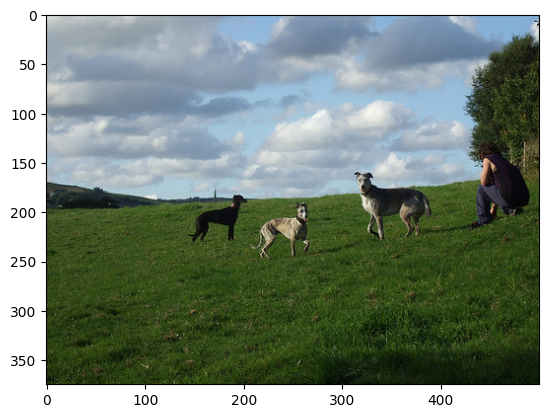

In [ ]:
caption = generate_caption("1032122270_ea6f0beedb.jpg")
speak_caption(caption)
